# Edge AI — RAG Evaluation
Tests retrieval quality, answer quality, and pipeline performance across both documents.

In [1]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath('../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

Project root: /home/bota/personal/edge_computing


In [2]:
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import time

from gateway.services.rag.embedder import Embedder
from gateway.services.rag.vector_store import VectorStore
from gateway.services.rag.retriever import Retriever
from gateway.services.rag.rag_service import RAGService

sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 4)

embedder  = Embedder()
store     = VectorStore(url='http://localhost:6333', collection='legal_docs')
retriever = Retriever(embedder, store, top_k=5)
rag       = RAGService(retriever, max_tokens=256, temperature=0.0)

print('✅ Pipeline ready')

✅ Pipeline ready


## 1. Test Cases

In [ ]:
TEST_CASES = [
    # (question, expected_keyword, document_id)
    ('What is the termination notice period?',           'notice',    'lease_agreement'),
    ('What are the payment terms?',                      'payment',   'lease_agreement'),
    ('Who is responsible for repairs?',                  'repair',    'lease_agreement'),
    ('What is the monthly rent?',                        'rent',      'lease_agreement'),
    ('What happens if rent is paid late?',               'late',      'lease_agreement'),
    ("What was Uber's total revenue in 2024?",           'revenue',   'uber-annual-report'),
    ("What are Uber's main business segments?",          'mobility',  'uber-annual-report'),
    ('What are the key risk factors for Uber?',          'risk',      'uber-annual-report'),
    ('How many monthly active platform consumers?',      'MAPC',      'uber-annual-report'),
    ("What is Uber's driver classification approach?",   'driver',    'uber-annual-report'),
    ("revenue total revenues consolidated statements of operations", 'revenue', "uber-annual-report")
]

print(f'{len(TEST_CASES)} test cases ready — {len([t for t in TEST_CASES if t[2]=="lease_agreement"])} lease, {len([t for t in TEST_CASES if t[2]=="uber-annual-report"])} Uber')

6 test cases ready — 0 lease, 6 Uber


## 2. Run Evaluation

In [10]:
async def run_eval():
    rows = []
    for q, keyword, doc_id in TEST_CASES:
        t0 = time.time()
        try:
            result    = await rag.query(q, document_id=doc_id)
            latency   = round(time.time() - t0, 2)
            answer    = result['answer']
            citations = result['citations']
            usage     = result.get('usage', {})

            top_score    = citations[0]['score'] if citations else 0.0
            has_answer   = answer != 'No relevant clause found.' and len(answer) > 20
            has_keyword  = keyword.lower() in answer.lower()
            has_citation = len(citations) > 0
            passed       = has_answer and has_keyword and has_citation

            rows.append({
                'question':       q,
                'document':       doc_id.replace('-', ' ').title(),
                'keyword':        keyword,
                'answered':       has_answer,
                'keyword_found':  has_keyword,
                'has_citation':   has_citation,
                'top_score':      top_score,
                'num_citations':  len(citations),
                'latency':        latency,
                'tokens':         usage.get('completion_tokens', 0),
                'tok_per_sec':    usage.get('tokens_per_sec', 0.0),
                'passed':         passed,
                'answer_preview': answer[:120],
            })
        except Exception as e:
            rows.append({
                'question': q, 'document': doc_id, 'keyword': keyword,
                'answered': False, 'keyword_found': False, 'has_citation': False,
                'top_score': 0.0, 'num_citations': 0, 'latency': 0,
                'tokens': 0, 'tok_per_sec': 0, 'passed': False,
                'answer_preview': f'ERROR: {e}',
            })
    return pd.DataFrame(rows)

df = await run_eval()

passed = df['passed'].sum()
total  = len(df)
print(f'\n📊 Score: {passed}/{total} passed ({100*passed//total}%)')
df[['question','document','top_score','latency','passed','answer_preview']]


📊 Score: 0/6 passed (0%)


,question,document,top_score,latency,passed,answer_preview
0,What was Uber's total revenue in 2024?,uber-annual-report,0.0,0,False,ERROR: All connection attempts failed
1,What are Uber's main business segments?,uber-annual-report,0.0,0,False,ERROR: All connection attempts failed
2,What are the key risk factors for Uber?,uber-annual-report,0.0,0,False,ERROR: All connection attempts failed
3,How many monthly active platform consumers?,uber-annual-report,0.0,0,False,ERROR: All connection attempts failed
4,What is Uber's driver classification approach?,uber-annual-report,0.0,0,False,ERROR: All connection attempts failed
5,revenue total revenues consolidated statements...,uber-annual-report,0.0,0,False,ERROR: All connection attempts failed


## 3. Retrieval Score Distribution

/tmp/ipykernel_54229/2772784953.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='document', y='top_score', palette='Blues', ax=axes[0])


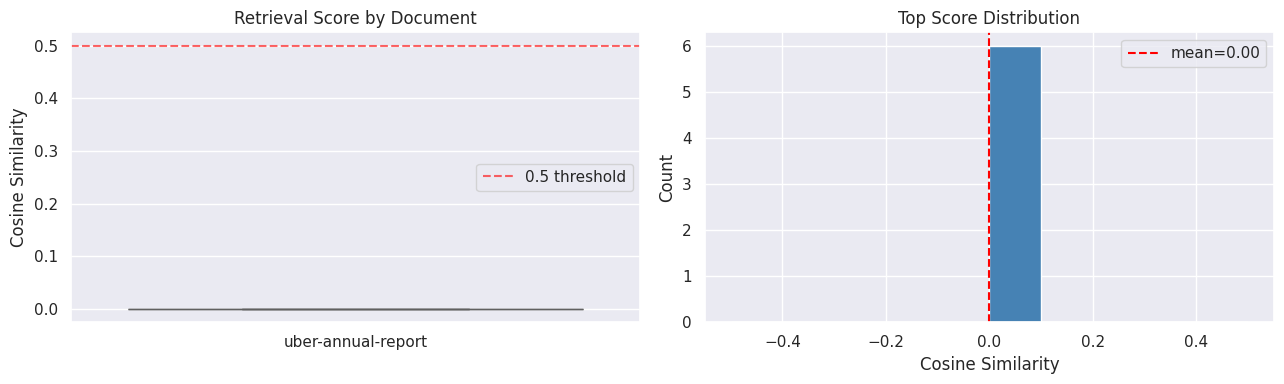

Avg: 0.000 | Min: 0.000 | Max: 0.000


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Score by document
sns.boxplot(data=df, x='document', y='top_score', palette='Blues', ax=axes[0])
axes[0].axhline(0.5, ls='--', color='red', alpha=0.6, label='0.5 threshold')
axes[0].set_title('Retrieval Score by Document')
axes[0].set_ylabel('Cosine Similarity')
axes[0].set_xlabel('')
axes[0].legend()

# Score histogram
axes[1].hist(df['top_score'], bins=10, color='steelblue', edgecolor='white')
axes[1].axvline(df['top_score'].mean(), color='red', ls='--', label=f"mean={df['top_score'].mean():.2f}")
axes[1].set_title('Top Score Distribution')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()
print(f"Avg: {df['top_score'].mean():.3f} | Min: {df['top_score'].min():.3f} | Max: {df['top_score'].max():.3f}")

## 4. Latency & Throughput

/tmp/ipykernel_54229/3212682604.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='document', y='latency', palette='Set2', ax=axes[1])


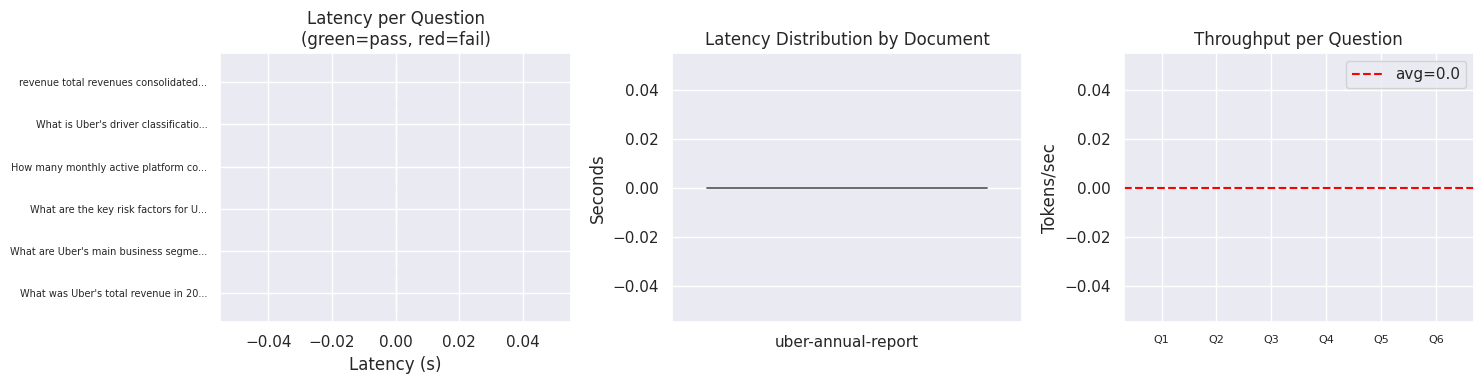

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Latency per question
colors = ['#2ecc71' if p else '#e74c3c' for p in df['passed']]
axes[0].barh(range(len(df)), df['latency'], color=colors)
axes[0].set_yticks(range(len(df)))
axes[0].set_yticklabels([q[:35]+'...' for q in df['question']], fontsize=7)
axes[0].set_xlabel('Latency (s)')
axes[0].set_title('Latency per Question\n(green=pass, red=fail)')

# Latency by document
sns.violinplot(data=df, x='document', y='latency', palette='Set2', ax=axes[1])
axes[1].set_title('Latency Distribution by Document')
axes[1].set_ylabel('Seconds')
axes[1].set_xlabel('')

# Tokens per second
axes[2].bar(range(len(df)), df['tok_per_sec'], color='steelblue')
axes[2].axhline(df['tok_per_sec'].mean(), color='red', ls='--', label=f"avg={df['tok_per_sec'].mean():.1f}")
axes[2].set_xticks(range(len(df)))
axes[2].set_xticklabels([f'Q{i+1}' for i in range(len(df))], fontsize=8)
axes[2].set_ylabel('Tokens/sec')
axes[2].set_title('Throughput per Question')
axes[2].legend()

plt.tight_layout()
plt.show()

## 5. Pass / Fail Breakdown

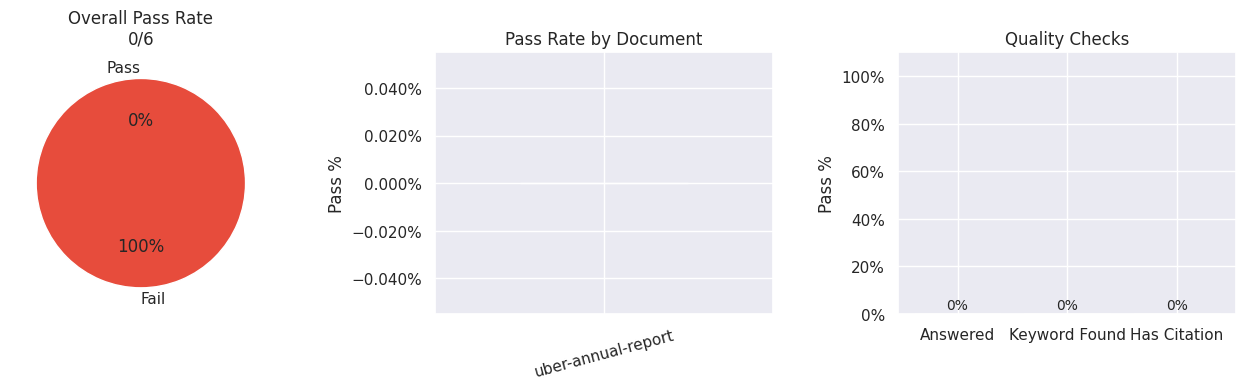

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Overall pass rate
counts = df['passed'].value_counts()
axes[0].pie(
    [counts.get(True, 0), counts.get(False, 0)],
    labels=['Pass', 'Fail'],
    colors=['#2ecc71', '#e74c3c'],
    autopct='%1.0f%%',
    startangle=90,
)
axes[0].set_title(f'Overall Pass Rate\n{passed}/{total}')

# Pass rate by document
pass_by_doc = df.groupby('document')['passed'].mean() * 100
pass_by_doc.plot(kind='bar', ax=axes[1], color=['#3498db', '#9b59b6'], edgecolor='white')
axes[1].set_title('Pass Rate by Document')
axes[1].set_ylabel('Pass %')
axes[1].set_xlabel('')
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].tick_params(axis='x', rotation=15)

# Check breakdown (answered / keyword / citation)
checks = {
    'Answered':      df['answered'].mean() * 100,
    'Keyword Found': df['keyword_found'].mean() * 100,
    'Has Citation':  df['has_citation'].mean() * 100,
}
axes[2].bar(checks.keys(), checks.values(), color=['#1abc9c', '#f39c12', '#3498db'], edgecolor='white')
axes[2].set_title('Quality Checks')
axes[2].set_ylabel('Pass %')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[2].set_ylim(0, 110)
for i, (k, v) in enumerate(checks.items()):
    axes[2].text(i, v + 2, f'{v:.0f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Score vs Latency — are harder retrievals slower?

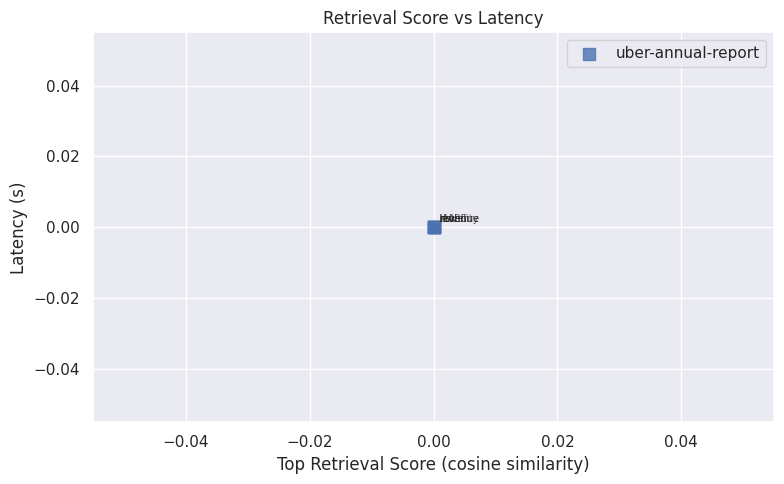

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

for doc, group in df.groupby('document'):
    ax.scatter(
        group['top_score'], group['latency'],
        label=doc, s=80, alpha=0.8,
        marker='o' if 'Lease' in doc else 's',
    )
    for _, row in group.iterrows():
        ax.annotate(
            row['keyword'],
            (row['top_score'], row['latency']),
            fontsize=7, alpha=0.7,
            xytext=(4, 4), textcoords='offset points',
        )

ax.set_xlabel('Top Retrieval Score (cosine similarity)')
ax.set_ylabel('Latency (s)')
ax.set_title('Retrieval Score vs Latency')
ax.legend()
plt.tight_layout()
plt.show()

## 7. Summary

In [9]:
print('=' * 55)
print('  RAG Evaluation Summary')
print('=' * 55)
print(f"  Pass rate        : {passed}/{total} ({100*passed//total}%)")
print(f"  Avg top score    : {df['top_score'].mean():.3f}")
print(f"  Avg latency      : {df['latency'].mean():.2f}s")
print(f"  Avg throughput   : {df['tok_per_sec'].mean():.1f} tok/s")
print(f"  Citation rate    : {df['has_citation'].mean()*100:.0f}%")
print('=' * 55)

fails = df[~df['passed']]
if len(fails):
    print(f"\n  Failed questions ({len(fails)}):")
    for _, r in fails.iterrows():
        print(f"  ❌ [{r['document']}] {r['question'][:55]}")
        print(f"     score={r['top_score']:.2f} | {r['answer_preview'][:80]}")
else:
    print('\n  ✅ All questions passed')

if df['top_score'].min() < 0.3:
    print('\n  ⚠️  Low scores detected — consider smaller child_max_tokens')
if df['latency'].max() > 30:
    print('\n  ⚠️  High latency — GPU may be under load')

  RAG Evaluation Summary
  Pass rate        : 0/6 (0%)
  Avg top score    : 0.000
  Avg latency      : 0.00s
  Avg throughput   : 0.0 tok/s
  Citation rate    : 0%

  Failed questions (6):
  ❌ [uber-annual-report] What was Uber's total revenue in 2024?
     score=0.00 | ERROR: All connection attempts failed
  ❌ [uber-annual-report] What are Uber's main business segments?
     score=0.00 | ERROR: All connection attempts failed
  ❌ [uber-annual-report] What are the key risk factors for Uber?
     score=0.00 | ERROR: All connection attempts failed
  ❌ [uber-annual-report] How many monthly active platform consumers?
     score=0.00 | ERROR: All connection attempts failed
  ❌ [uber-annual-report] What is Uber's driver classification approach?
     score=0.00 | ERROR: All connection attempts failed
  ❌ [uber-annual-report] revenue total revenues consolidated statements of opera
     score=0.00 | ERROR: All connection attempts failed

  ⚠️  Low scores detected — consider smaller child_max_tok